In [1]:
#Load the modules for data manipulation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Load the module for visualizing NYC.
import geopandas as gpd
#Load the module for suppressing unwanted error messages.
import warnings
warnings.filterwarnings('ignore')

#Adjust visualization settings.
#sns.set_style()
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#Load the Shapefile for NYC into a dataframe. The Shapefile is used to visualize NYC, and was retrieved from NYC Open Data. 
street_map = gpd.read_file('geo_export_629b3182-5516-4755-987b-f4106c7d8b99.shp')

#Load the dataset, but exclude unnecessary columns.
shops = pd.read_csv('shops_post_EDA.csv')
shops = shops.loc[:, 'reviews':]

shops.tail()

,reviews,rating,latitude,longitude,price
4031,159,7,40.635274,-74.026368,x
4032,764,7,40.721262,-73.996989,xx
4033,1889,8,40.718423,-73.957428,xx
4034,29,0,40.629940,-74.076400,x
4035,29,1,40.629960,-74.076406,x


In [3]:
def distance(x1,y1,x2,y2):
    """This computes the Euclidean distance between (x1,y1) and (x2,y2)."""
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [4]:
def adjacencies_dictionary(max_distance):
    """
    •This returns a dictionary whose keys are the coffee shop id's, and the value associated with each key is a list of 
    shops no further than max_distance away from the key. 
    •There is no 'id' column, but rather the shop id's are represented by implicit row indices (0,1,2...)
    •Takes 25-27 minutes to run.
    """
    S = {}
    for i in range(shops.shape[0]):
        longitude = shops['longitude'][i]
        latitude = shops['latitude'][i]
        neighbors = []
        for j in range(shops.shape[0]):
            longitude_potential_neighbor = shops['longitude'][j]
            latitude_potential_neighbor = shops['latitude'][j]
            distance_potential_neighbor = distance(longitude, latitude, 
                                                   longitude_potential_neighbor, latitude_potential_neighbor)
            if distance_potential_neighbor <= max_distance and j!=i:
                neighbors.append(j)
        S[i] = neighbors
    return S

In [5]:
#Because adjacencies_dictionary takes 25+ minutes to compute, it is more time-efficient to build some adjacency dictionaries
# in advance which can then be used within function definitions, rather than computing them each time the function is called.
adj_dict_001 = adjacencies_dictionary(0.001)
adj_dict_002 = adjacencies_dictionary(0.002)
adj_dict_003 = adjacencies_dictionary(0.003)
adj_dict_004 = adjacencies_dictionary(0.004)
adj_dict_005 = adjacencies_dictionary(0.005)
adj_dict_01 = adjacencies_dictionary(0.01)
adj_dict_02 = adjacencies_dictionary(0.02)

In [7]:
#neighbor list of node with key 2748 when max_distance=0.001
adj_dict_001[2748]

[59, 2352, 2935, 2958, 3741]

In [8]:
def degree_dictionary(adjacencies_dict):
    """
    •This returns a dictionary whose keys are the coffee shop id's and whose corresponding values are their degrees.
    •adjacencies_dict is of the form of the output of adjacencies_dictionary(), e.g. adj_dict_001.
    •Runs in one second.
    """
    S = {}
    for shop_id in adjacencies_dict:
        S[shop_id] = len(adjacencies_dict[shop_id])
    return S

In [9]:
def max_degree(degree_dict):
    """
    •This returns the maximum number of neighbors among the nodes in the network.
    •degree_dict is of the form of the output of degree_dictionary(), e.g. deg_dict_001.
    """
    maximum = 0
    for shop_id in degree_dict:
        if degree_dict[shop_id] > maximum:
            maximum = degree_dict[shop_id]
    return maximum

def avg_degree(degree_dict):
    """
    •This returns the average number of neighbors among the nodes in the network.
    •degree_dict is of the form of the output of degree_dictionary().
    """
    degree_sum = 0
    for shop_id in degree_dict:
        degree_sum += degree_dict[shop_id]
    degree_average = degree_sum / len(degree_dict)
    return degree_average

In [10]:
#Create a degree dictionary for various max_distance values.
deg_dict_001 = degree_dictionary(adj_dict_001)
deg_dict_002 = degree_dictionary(adj_dict_002)
deg_dict_003 = degree_dictionary(adj_dict_003)
deg_dict_004 = degree_dictionary(adj_dict_004)
deg_dict_005 = degree_dictionary(adj_dict_005)
deg_dict_01 = degree_dictionary(adj_dict_01)
deg_dict_02 = degree_dictionary(adj_dict_02)

#Inspect the maximum and average degrees from the adjacency dictionaries constructed above.
#This will give an idea of an appropriate range for max_distance; the degrees should neither be too low nor too high.
[[max_degree(deg_dict_001), avg_degree(deg_dict_001)],
 [max_degree(deg_dict_002), avg_degree(deg_dict_002)],
 [max_degree(deg_dict_003), avg_degree(deg_dict_003)],
 [max_degree(deg_dict_004), avg_degree(deg_dict_004)],
 [max_degree(deg_dict_005), avg_degree(deg_dict_005)],
 [max_degree(deg_dict_01), avg_degree(deg_dict_01)],
 [max_degree(deg_dict_02), avg_degree(deg_dict_02)]]

[[15, 2.2170465807730424],
 [44, 6.993062438057483],
 [66, 13.965807730426164],
 [95, 23.0406342913776],
 [122, 33.9786917740337],
 [390, 112.90733399405352],
 [968, 333.23934588701684]]

In [11]:
#The first version of the trend simulator; in future versions I will ramp up the complexity by including more conditions.
def trend_adoption(adj_dict, iterations=0, p_x=0.0025, p_xx=0.0025, p_xxx=0.0025, p_xxxx=0.0025, seed=34):
    """
    •This returns a dataframe of Boolean values, where each row corresponds to a shop, each column an iteration, and a
    cell is True if that shop is making use of the trend in that iteration.
    •adj_dict is in the form of the output of adjacencies_dictionary(), e.g. adj_dict_001.
    •p_x, p_xx, p_xxx, p_xxxx are the initial adoption probabilities for price 'x', 'xx', 'xxx', 'xxxx' shops respectively.
    •iterations = n updates the network n times beyond the random initialization step.
    •seed is a random seed for the binomial distributions (used in the random initialization step).
    •Takes a minute to run with iterations=10.
    """
    
    #Creating the adoptions dataframe with all iterations set to False before initialization.
    #Each row corresponds to one shop; each column corresponds to one iteration, it_0, it_1, ..., it_iterations
    adoptions = np.array([[False]*(iterations+1) for i in range(shops.shape[0])])
    adoptions = pd.DataFrame(adoptions, columns=[['it_{}'.format(i) for i in range(iterations+1)]])
    
    #Random initialization; iteration 0.
    np.random.seed(seed)
    for i in range(shops.shape[0]):
        price = shops['price'][i]
        if price == 'x':
            did_adopt = bool(np.random.binomial(1, p_x))
        if price == 'xx':
            did_adopt = bool(np.random.binomial(1, p_xx))
        if price == 'xxx':
            did_adopt = bool(np.random.binomial(1, p_xxx))
        if price == 'xxxx':
            did_adopt = bool(np.random.binomial(1, p_xxxx))
        #If the initialization state for a shop is True then all subsequent states are True, according to below simulation conditions.
        if did_adopt == True:
            adoptions.iloc[i, :] = True
            
    #Updating the network of coffee shops; each iteration corresponds to one update of the trend adoption state for each of the shops.
    #First simulation conditions: 
    #   i) If a node is True at iteration i, then it is true at all iterations j>i.
    #   ii)If a node is False at iteration i but has at least one neighbor that is True, and if iteration i is not the last iteration, then the node updates to True for iteration i+1.
    for iteration in range(1, iterations+1):
        for i in range(shops.shape[0]):
            #If the shop is already True, that means all subsequent values are already True, so we can skip ahead to the next shop.
            if adoptions.iloc[i, iteration] == True:
                continue
            else:
                #shop i is currently False; if any of i's neighbors are already True then i becomes True for all remaining iterations.
                neighbors = adj_dict[i]
                for j in neighbors:
                    neighbor_previous_state = adoptions.iloc[j, iteration-1]
                    #If neighbor_previous_state is True, then the current shop must be updated to True for all iterations, and we need not check more of its neighbors.
                    if neighbor_previous_state == True:
                        adoptions.iloc[i, iteration:] = True
                        break
    
    return adoptions

In [12]:
#This function runs the trend_adoption() simulator for each (init_prob, seed) pair as a way to test different initialization probabilities for a given distance.
#It accepts a list of random seeds so that multiple runs of the simulator can be performed, thereby giving a larger sample size.
#It assumes that p_x, p_xx, p_xxx and p_xxxx are all equal to init_prob.

def prob_seed_adoption(adj_dict=adj_dict_002, init_probs=[0.01,0.02,0.03], seeds=[1,2], num_iterations=4):
    """
    •This outputs a dataframe with rows indexed by (init_prob, seed) pairs and columns 'i_0', 'i_1', ..., 'i_num_terations'.
    •The entry in a cell is a count of how many shops are True in the corresponding iteration when all shops have the same
    initialization probability init_prob and when seed is used for the random seed value.
    """
    #Creating the multi index for the rows.
    multi_index = []
    for init_prob in init_probs:
        for seed in seeds:
            multi_index.append((init_prob, seed))

    #Build the skeleton for the output dataframe.      
    seed_init_df = pd.DataFrame(index=multi_index, columns=[['it_{}'.format(i) for i in range(num_iterations+1)]])
    seed_init_df.index = pd.MultiIndex.from_tuples(multi_index, names=['init_prob', 'seed'])
    seed_init_df

    #Fill in the cells in seed_init_df.
    for i_p in init_probs:
        for seed in seeds:
            t_a = trend_adoption(adj_dict, 
                                 iterations = num_iterations, 
                                 p_x = i_p, 
                                 p_xx = i_p,
                                 p_xxx = i_p, 
                                 p_xxxx = i_p, 
                                 seed = seed)
            
            #Copy the column sums from t_a to seed_init_df row indexed with (i_p, seed).
            seed_init_df.loc[(i_p, seed)] = list(np.sum(t_a))
            
    return seed_init_df

In [13]:
#Run the simulator 100 times for each (max_distance, init_prob) pair.

prob_seed_adoption_001 = prob_seed_adoption(adj_dict=adj_dict_001,
                                            init_probs=[0.0005, 0.0010, 0.0015, 0.0020, 0.0025], 
                                            seeds=[17*i for i in range(1,101)], 
                                            num_iterations=4)

prob_seed_adoption_002 = prob_seed_adoption(adj_dict=adj_dict_002, 
                                            init_probs=[0.0005, 0.0010, 0.0015, 0.0020, 0.0025], 
                                            seeds=[17*i for i in range(1,101)], 
                                            num_iterations=4)

prob_seed_adoption_003 = prob_seed_adoption(adj_dict=adj_dict_003, 
                                            init_probs=[0.0005, 0.0010, 0.0015, 0.0020, 0.0025], 
                                            seeds=[17*i for i in range(1,101)], 
                                            num_iterations=4)

prob_seed_adoption_004 = prob_seed_adoption(adj_dict=adj_dict_004, 
                                            init_probs=[0.0005, 0.0010, 0.0015, 0.0020, 0.0025], 
                                            seeds=[17*i for i in range(1,101)], 
                                            num_iterations=4)

Take the mean number of True states over 100 seeds for each (max_distance, init_prob, iteration) triple.
This gives an idea of how fast the trend spreads for the given values.

In [14]:
#max_distance=0.001
prob_seed_adoption_001.groupby('init_prob').mean().astype('int')

,it_0,it_1,it_2,it_3,it_4
init_prob,,,,,
0.0005,2,6,10,13,16
0.0010,3,12,18,23,28
0.0015,5,18,26,34,41
0.0020,7,23,35,45,54
0.0025,9,30,44,58,68


In [15]:
#max_distance=0.002
prob_seed_adoption_002.groupby('init_prob').mean().astype('int')

,it_0,it_1,it_2,it_3,it_4
init_prob,,,,,
0.0005,2,16,35,61,92
0.0010,3,30,65,110,164
0.0015,5,43,93,157,232
0.0020,7,57,122,203,297
0.0025,9,72,153,254,370


In [16]:
#max_distance=0.003
prob_seed_adoption_003.groupby('init_prob').mean().astype('int')

,it_0,it_1,it_2,it_3,it_4
init_prob,,,,,
0.0005,2,31,78,147,223
0.0010,3,57,142,260,388
0.0015,5,82,202,364,535
0.0020,7,106,259,461,673
0.0025,9,134,326,572,818


In [17]:
#max_distance=0.004
prob_seed_adoption_004.groupby('init_prob').mean().astype('int')

,it_0,it_1,it_2,it_3,it_4
init_prob,,,,,
0.0005,2,49,137,249,371
0.0010,3,89,244,431,624
0.0015,5,129,344,593,836
0.0020,7,167,438,747,1022
0.0025,9,211,545,905,1207


In [18]:
#Running a simulation with max_distance=0.001 and init_prob=0.0025.
#The resulting dataframe will be concatenated with the shops dataframe.
#This will allow us to visualize the True shops at each iteration of the simulation using their coordinates.

#Run the simulation
t_a_001_0025_34 = trend_adoption(adj_dict_001, iterations=10, p_x=0.0025, p_xx=0.0025, p_xxx=0.0025, p_xxxx=0.0025, seed=34)

#Concatenate shops and simulation table
simulation_001_0025_34 = shops
for i in range(t_a_001_0025_34.shape[1]):
    simulation_001_0025_34['it_{}'.format(i)] = t_a_001_0025_34['it_{}'.format(i)]

simulation_001_0025_34.head()  

,reviews,rating,latitude,longitude,price,it_0,it_1,it_2,it_3,it_4,it_5,it_6,it_7,it_8,it_9,it_10
0,641,9,40.726990,-73.989220,xx,False,False,False,False,False,False,False,False,False,False,False
1,499,8,40.704228,-73.986241,xx,False,False,False,False,False,False,False,False,False,False,False
2,399,8,40.716083,-73.964752,xx,False,False,False,False,False,False,False,False,False,False,False
3,136,9,40.718703,-74.000473,xx,False,False,False,False,False,False,False,False,False,False,False
4,164,9,40.688270,-73.987569,xx,False,False,False,False,False,False,False,False,False,False,False


Visualize the True shops at each of it_0, it_1, ..., it_10 for max_distance=0.001, init_prob=0.0025. I forget what I had set as the default seed for trend_adoption() at the time that the simulation was run.

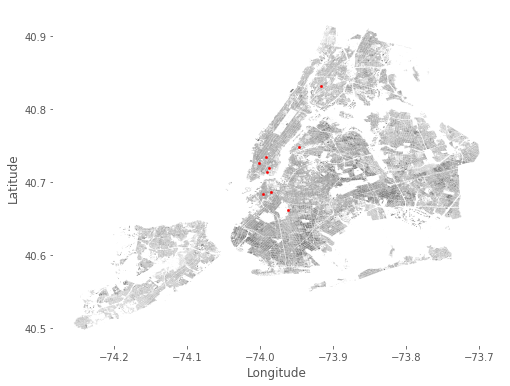

In [455]:
#Iteration 0 (initialization step)
data = simulation_001_0025_34[simulation_001_0025_34['it_0']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

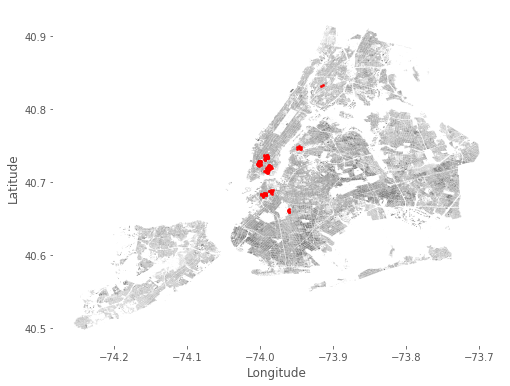

In [456]:
#Iteration 1
data = simulation_001_0025_34[simulation_001_0025_34['it_1']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

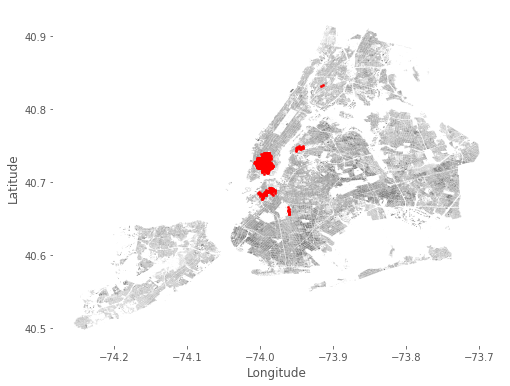

In [460]:
#Iteration 2
data = simulation_001_0025_34[simulation_001_0025_34['it_2']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

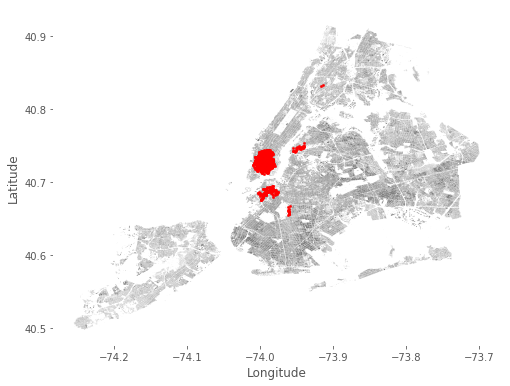

In [461]:
#Iteration 3
data = simulation_001_0025_34[simulation_001_0025_34['it_3']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

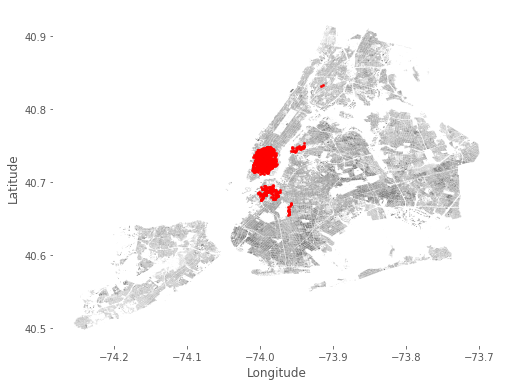

In [462]:
#Iteration 4
data = simulation_001_0025_34[simulation_001_0025_34['it_4']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

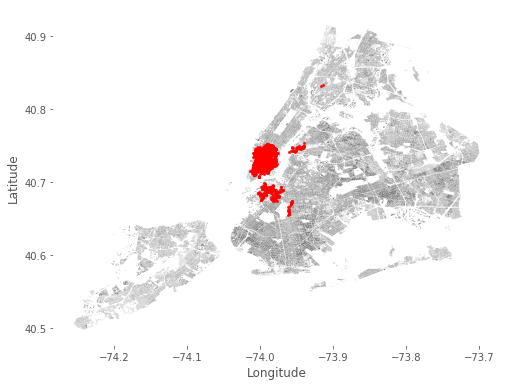

In [463]:
#Iteration 5
data = simulation_001_0025_34[simulation_001_0025_34['it_5']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

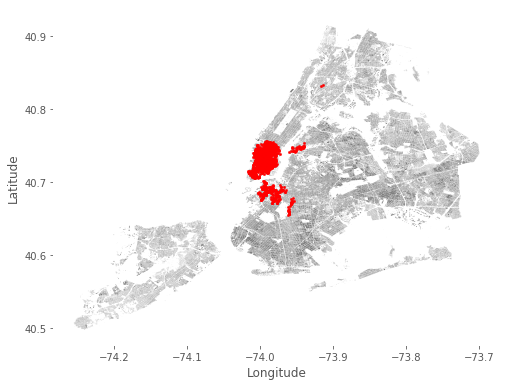

In [464]:
#Iteration 6
data = simulation_001_0025_34[simulation_001_0025_34['it_6']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

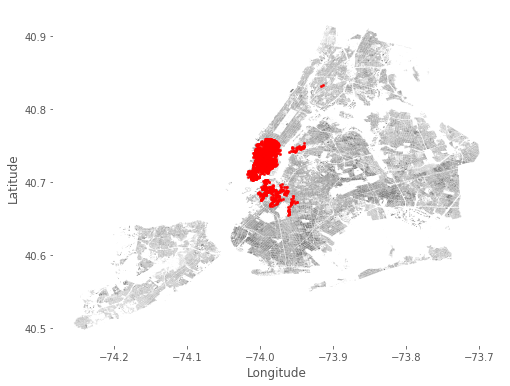

In [465]:
#Iteration 7
data = simulation_001_0025_34[simulation_001_0025_34['it_7']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

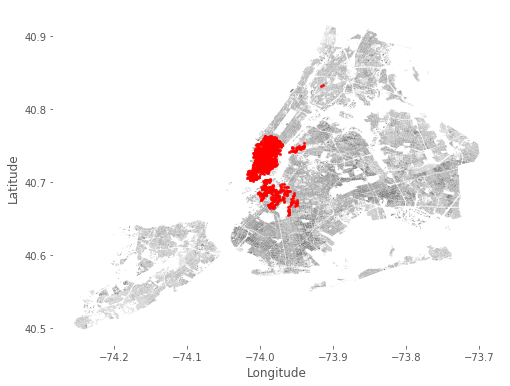

In [466]:
#Iteration 8
data = simulation_001_0025_34[simulation_001_0025_34['it_8']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

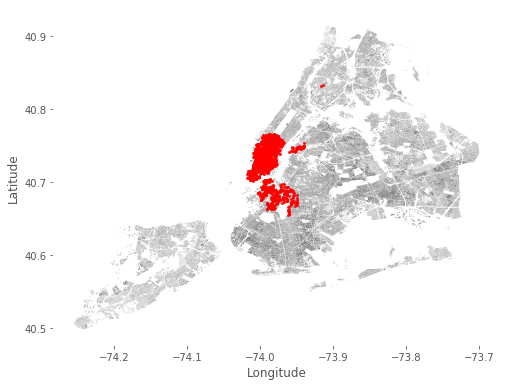

In [467]:
#Iteration 9
data = simulation_001_0025_34[simulation_001_0025_34['it_9']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');

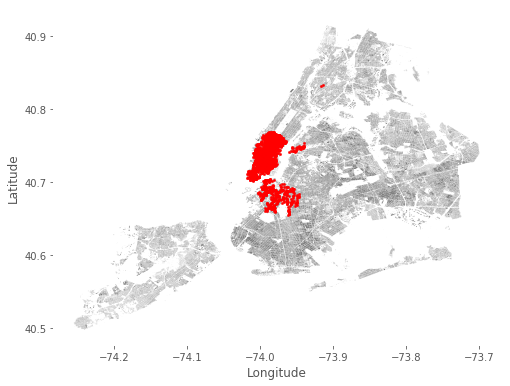

In [457]:
#Iteration 10
data = simulation_001_0025_34[simulation_001_0025_34['it_10']==True]

fig, ax = plt.subplots(figsize=(8,8))
ax.set(xlabel='Longitude', ylabel='Latitude')
street_map.plot(ax=ax, alpha=1, color='grey')
plt.scatter(x='longitude', y='latitude', c='red', s=5, data=data)
ax.patch.set_facecolor('white');